In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  1 02:15:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# #reference: 
# #https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903

# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy
!pip install gdown
!pip install torchvision
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 4.8 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=394079 sha256=a7f1ba0d38bc5c5daf31e6a42e8e7f706a392c8fdff4724cddd8945a3de95ade
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
Successfully built annoy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 2.1 MB/s 


In [ ]:
import fastai; fastai.__version__

'2.7.10'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
from zipfile import ZipFile
import urllib.request
import os
import requests
import subprocess
from bs4 import BeautifulSoup
import tldextract
import torch
import torchvision

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Thu Dec  1 02:16:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [ ]:
fashion_df = pd.read_json("/content/fashion.json",lines=True)
fashion_df.head()

,product,scene,bbox
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]"
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]"
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]"
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]"
4,002a6586b8381b5efd39410657630b44,67ed2a06be8a26dc63d7a04d4e1a135f,"[0.154545, 0.144809, 0.809091, 0.784153]"


In [ ]:
fashion_cat_df = pd.read_json("/content/fashion-cat.json", typ = 'series')
fashion_cat_df.head()

8870b0d384138a81cfdc91f98d1dde9b                     Apparel & Accessories|Shoes
70d392390fa258ba9b5d6b83ea29857e                     Apparel & Accessories|Shoes
2c05db9ff1abbcfc4bfd50dd003aac80            Apparel & Accessories|Clothing|Pants
2b2cc3a8b588b7282be0511568b51ee7    Apparel & Accessories|Clothing|Shirts & Tops
a141ed588bdaeccf1f695889a5aa7085           Apparel & Accessories|Clothing|Shorts
dtype: object

In [ ]:
fashion_cat_df = pd.DataFrame(fashion_cat_df)
fashion_cat_df.reset_index(inplace = True)
col_names = ['product', 'label']
fashion_cat_df.columns = col_names
fashion_cat_df.head()

,product,label
0,8870b0d384138a81cfdc91f98d1dde9b,Apparel & Accessories|Shoes
1,70d392390fa258ba9b5d6b83ea29857e,Apparel & Accessories|Shoes
2,2c05db9ff1abbcfc4bfd50dd003aac80,Apparel & Accessories|Clothing|Pants
3,2b2cc3a8b588b7282be0511568b51ee7,Apparel & Accessories|Clothing|Shirts & Tops
4,a141ed588bdaeccf1f695889a5aa7085,Apparel & Accessories|Clothing|Shorts


In [ ]:
new_fashion_df = pd.merge(fashion_df, fashion_cat_df, on="product")
new_fashion_df.head()

,product,scene,bbox,label
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]",Apparel & Accessories|Shoes
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]",Apparel & Accessories|Shoes
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]",Apparel & Accessories|Shoes
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]",Apparel & Accessories|Shoes
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,"[0.641984, 0.773521, 0.804771, 0.8605459999999999]",Apparel & Accessories|Shoes


In [ ]:
col_list = new_fashion_df.label.values.tolist()
label_list = []
for lab in col_list:
  new_label = lab.split('|')[-1]
  label_list.append(new_label)

label_df = pd.DataFrame(label_list, columns = ['label'])

In [ ]:
new_fashion_df['label'] = label_df
new_fashion_df.head()

,product,scene,bbox,label
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,"[0.43409699999999996, 0.859363, 0.560254, 1.0]",Shoes
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,"[0.17526899999999998, 0.5277729999999999, 0.621485, 0.9248989999999999]",Shoes
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,"[0.588666, 0.6385029999999999, 0.750647, 0.7613679999999999]",Shoes
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,"[0.276699, 0.757741, 0.400485, 0.876138]",Shoes
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,"[0.641984, 0.773521, 0.804771, 0.8605459999999999]",Shoes


In [ ]:
# new_fashion_df.isnull.sum()
type(new_fashion_df)

pandas.core.frame.DataFrame

In [ ]:
len(new_fashion_df)

72198

In [ ]:
len(new_fashion_df.label.unique())

10

In [ ]:
new_fashion_df[['product','label']].groupby('label').count()

,product
label,
Coats & Jackets,4788
Earrings,1507
"Handbags, Wallets & Cases",6322
Necklaces,1428
Pants,14289
Shirts & Tops,11957
Shoes,22706
Shorts,2752
Skirts,1872


In [ ]:
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

In [ ]:
product_image_urls = []
name = 'images'
for i in range(10000):
    product_image_url = convert_to_url(fashion_df['product'].iloc[i])
    product_image_urls.append(product_image_url)

In [ ]:
os.mkdir('/content/product_images')
os.chdir('/content/product_images')
print(os.getcwd())

/content/product_images


In [ ]:
for img in product_image_urls:
    # We can split the file based upon / and extract the last split within the python list below:
    file_name = img.split('/')[-1]
    # print(f"This is the file name: {file_name}")
    # Now let's send a request to the image URL:

    r = requests.get(img, stream=True)
    # We can check that the status code is 200 before doing anything else:
    if r.status_code == 200:
        # This command below will allow us to write the data to a file as binary:
        with open(file_name, 'wb') as f:
            for chunk in r:
                f.write(chunk)
    else:
        # We will write all of the images back to the broken_images list:
        product_image_urls.append(img)

# product_image_urls:

In [ ]:
os.mkdir('/content/scene_images')
os.chdir('/content/scene_images')
print(os.getcwd())

/content/scene_images


In [ ]:
scene_image_urls = []
name = 'images'
for i in range(10000):
    scene_image_url = convert_to_url(fashion_df['scene'].iloc[i])
    scene_image_urls.append(scene_image_url)

In [ ]:
for img in scene_image_urls:
    # We can split the file based upon / and extract the last split within the python list below:
    file_name = img.split('/')[-1]
    # print(f"This is the file name: {file_name}")
    # Now let's send a request to the image URL:

    r = requests.get(img, stream=True)
    # We can check that the status code is 200 before doing anything else:
    if r.status_code == 200:
        # This command below will allow us to write the data to a file as binary:
        with open(file_name, 'wb') as f:
            for chunk in r:
                f.write(chunk)
    else:
        # We will write all of the images back to the broken_images list:
        scene_image_urls.append(img)

# scene_image_urls

In [ ]:
cols_to_drop = ['bbox']
new_fashion_df.drop(columns = cols_to_drop, axis = 1, inplace = True) 

In [ ]:
new_df = new_fashion_df[0:10000].copy()

In [ ]:
new_df.head()

In [ ]:
import numpy
dataset = list(numpy.random.choice(['train', 'test','val'], size=10000, p=[.6, .2,.2]))
new_df['dataset'] = dataset
new_df.head()

,product,scene,label,dataset
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,Shoes,test
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,Shoes,train
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,Shoes,test
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,Shoes,val
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,Shoes,train


In [ ]:
product_path = []
scene_path = []
for i in range(len(new_df)):
  product_path.append('/content/product_images/'+ new_df['product'].iloc[i]+'.jpg')
  scene_path.append('/content/scene_images/'+ new_df['scene'].iloc[i]+'.jpg')

In [ ]:
new_df['product_path'] = product_path
new_df['scene_path'] = scene_path
new_df.head()

,product,scene,label,dataset,product_path,scene_path
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/cdab9160072dd1800038227960ff6467.jpg
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/14f59334af4539132981b1324a731067.jpg
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/e7d32df9f45b691afc580808750f73ca.jpg
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,Shoes,val,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/c0be585ed21b1a6c6dc9559ebe007ede.jpg
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/fa5292c6c728810f6bfee095a3824dbd.jpg


In [ ]:
new_df2 = new_df.copy()
new_df2.head()

,product,scene,label,dataset,product_path,scene_path
0,0027e30879ce3d87f82f699f148bff7e,cdab9160072dd1800038227960ff6467,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/cdab9160072dd1800038227960ff6467.jpg
1,0027e30879ce3d87f82f699f148bff7e,14f59334af4539132981b1324a731067,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/14f59334af4539132981b1324a731067.jpg
2,0027e30879ce3d87f82f699f148bff7e,e7d32df9f45b691afc580808750f73ca,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/e7d32df9f45b691afc580808750f73ca.jpg
3,0027e30879ce3d87f82f699f148bff7e,c0be585ed21b1a6c6dc9559ebe007ede,Shoes,val,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/c0be585ed21b1a6c6dc9559ebe007ede.jpg
4,0027e30879ce3d87f82f699f148bff7e,fa5292c6c728810f6bfee095a3824dbd,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,/content/scene_images/fa5292c6c728810f6bfee095a3824dbd.jpg


In [ ]:
cols_to_drop = ['product', 'scene', 'scene_path']
new_df.drop(columns = cols_to_drop, axis = 1, inplace = True) 
prod_df = new_df
prod_df.head()

,label,dataset,product_path
0,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg
1,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg
2,Shoes,test,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg
3,Shoes,val,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg
4,Shoes,train,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg


In [ ]:
prod_df = prod_df[['product_path', 'label']]
prod_df.head()

,product_path,label
0,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,Shoes
1,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,Shoes
2,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,Shoes
3,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,Shoes
4,/content/product_images/0027e30879ce3d87f82f699f148bff7e.jpg,Shoes


In [ ]:
cols_to_drop = ['product', 'scene', 'product_path']
new_df2.drop(columns = cols_to_drop, axis = 1, inplace = True) 
scene_df = new_df2
scene_df.head()

,label,dataset,scene_path
0,Shoes,test,/content/scene_images/cdab9160072dd1800038227960ff6467.jpg
1,Shoes,train,/content/scene_images/14f59334af4539132981b1324a731067.jpg
2,Shoes,test,/content/scene_images/e7d32df9f45b691afc580808750f73ca.jpg
3,Shoes,val,/content/scene_images/c0be585ed21b1a6c6dc9559ebe007ede.jpg
4,Shoes,train,/content/scene_images/fa5292c6c728810f6bfee095a3824dbd.jpg


In [ ]:
scene_df = scene_df[['scene_path', 'label']]
scene_df.head()

,scene_path,label
0,/content/scene_images/cdab9160072dd1800038227960ff6467.jpg,Shoes
1,/content/scene_images/14f59334af4539132981b1324a731067.jpg,Shoes
2,/content/scene_images/e7d32df9f45b691afc580808750f73ca.jpg,Shoes
3,/content/scene_images/c0be585ed21b1a6c6dc9559ebe007ede.jpg,Shoes
4,/content/scene_images/fa5292c6c728810f6bfee095a3824dbd.jpg,Shoes


In [ ]:
train_prod_df = prod_df[0:8000]
test_prod_df = prod_df[8001:10000]

In [ ]:
from fastai.vision.all import *

In [ ]:
images_transformations = Resize(64)

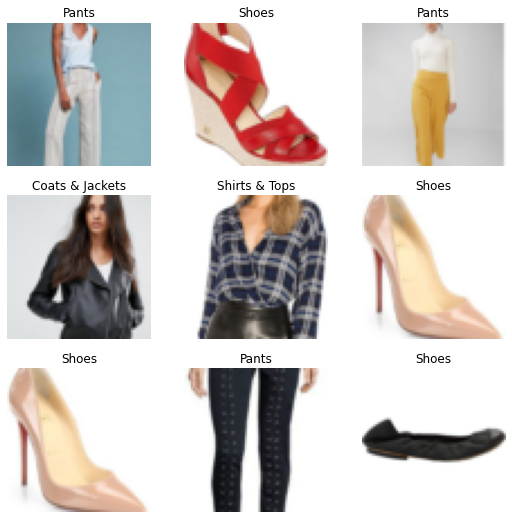

In [ ]:
train_prod_dls = ImageDataLoaders.from_df(train_prod_df, path='/', item_tfms = images_transformations)
train_prod_dls.valid.show_batch(max_n = 9)

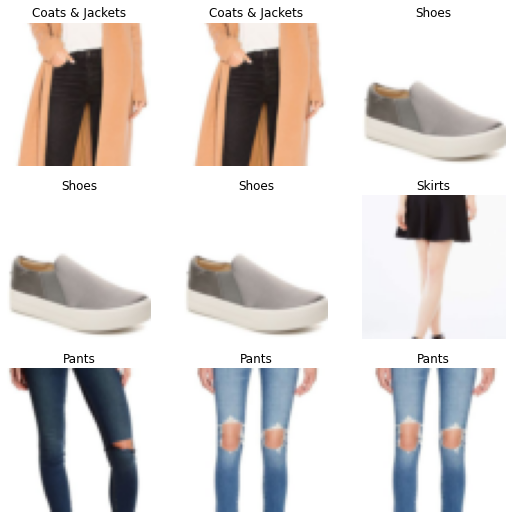

In [ ]:
data = train_prod_dls

test_prod_dls = ImageDataLoaders.from_df(test_prod_df, path='/', item_tfms = images_transformations)
dl = test_prod_dls.test_dl(test_prod_df, with_labels=True)
dl.show_batch(max_n = 9)

In [ ]:
import torchvision.models as models
from functools import partial

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


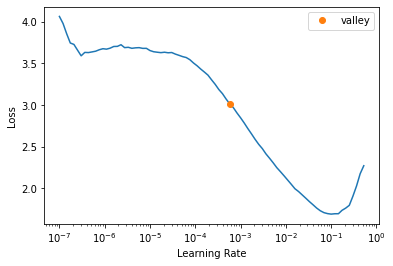

In [ ]:
def train_model(data, pretrained_model, model_metrics):
  learner = vision_learner(data, pretrained_model, metrics=model_metrics)
  learner.model = torch.nn.DataParallel(learner.model)
  learner.lr_find()
  # learner.recorder.plot(suggestion=True)
  return learner
vgg19 = models.vgg19  
resnet18 = models.resnet18
resnet50 = models.resnet50

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner_resnet50 = train_model(data, resnet50, model_metrics)


In [ ]:
learner_resnet50

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


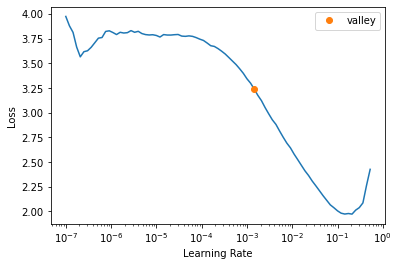

In [ ]:
learner_resnet18 = train_model(data, resnet18, model_metrics)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

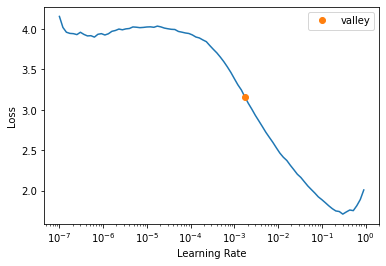

In [ ]:
learner_vgg19 = train_model(data, vgg19, model_metrics)

In [ ]:
learner_vgg19.fit_one_cycle(10, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.281890,0.934772,0.881250,0.881250,0.987500,00:02
1,0.949091,1.328826,0.881250,0.881250,0.987500,00:02
2,0.946426,3.227501,0.875000,0.875000,0.943750,00:02
3,1.099468,2.916937,0.893750,0.893750,0.943750,00:02
4,1.202435,3.938525,0.875000,0.875000,0.968750,00:02
5,1.257110,3.181883,0.887500,0.887500,0.962500,00:02
6,1.197060,2.322283,0.918750,0.918750,0.968750,00:03
7,1.099974,2.072964,0.912500,0.912500,0.981250,00:03
8,1.004048,2.205460,0.912500,0.912500,0.981250,00:02
9,0.909991,2.315714,0.918750,0.918750,0.981250,00:02


In [ ]:
learner_resnet50.fit_one_cycle(100, lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.018762,1.338321,0.525000,0.525000,0.900000,00:01
1,2.212759,0.767444,0.725000,0.725000,0.975000,00:01
2,1.697012,0.468478,0.900000,0.900000,1.000000,00:01
3,1.399891,0.288826,0.900000,0.900000,1.000000,00:01
4,1.177570,0.188033,0.875000,0.875000,1.000000,00:01
5,0.985579,0.168958,0.925000,0.925000,1.000000,00:01
6,0.846683,0.158265,0.925000,0.925000,1.000000,00:01
7,0.735936,0.171032,0.950000,0.950000,1.000000,00:01
8,0.659250,0.178194,0.950000,0.950000,1.000000,00:01
9,0.593517,0.174996,0.950000,0.950000,1.000000,00:01


In [ ]:
learner_resnet18.fit_one_cycle(10, lr_max=0.1) 


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.583636,3.253174,0.750000,0.750000,0.925000,00:02
1,1.413277,51.729912,0.412500,0.412500,0.693750,00:02
2,1.603441,29.162802,0.325000,0.325000,0.806250,00:02
3,1.731460,13.666654,0.518750,0.518750,0.843750,00:02
4,1.657405,3.630556,0.618750,0.618750,0.762500,00:02
5,1.508884,1.203048,0.768750,0.768750,0.937500,00:02
6,1.309608,0.918103,0.856250,0.856250,0.962500,00:02
7,1.151235,0.636705,0.887500,0.887500,0.968750,00:02
8,0.983856,0.684762,0.875000,0.875000,0.968750,00:02
9,0.857777,0.708545,0.875000,0.875000,0.968750,00:02


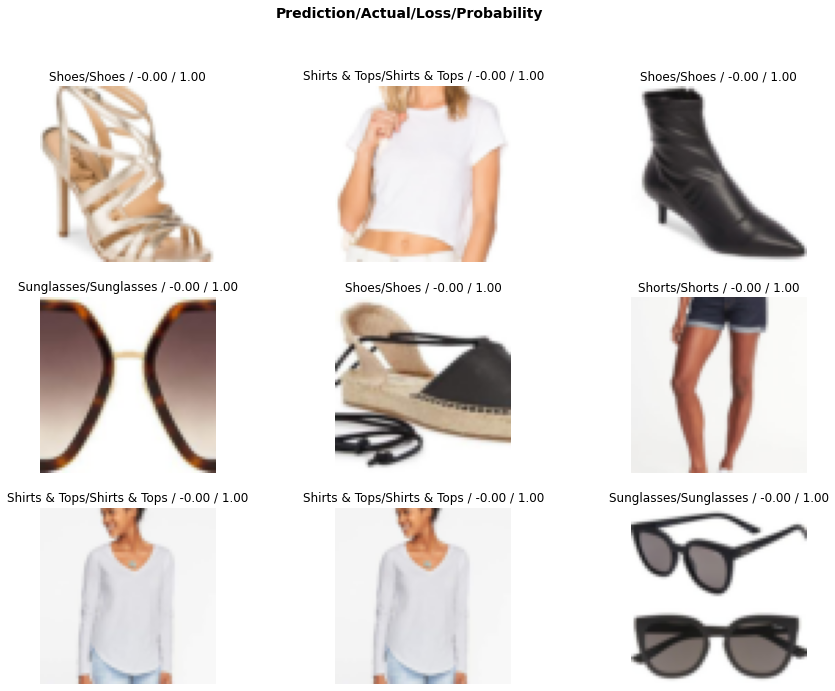

In [ ]:
interp_vgg19 = ClassificationInterpretation.from_learner(learner_vgg19)
interp_vgg19.plot_top_losses(9, largest=False, figsize=(15,11))

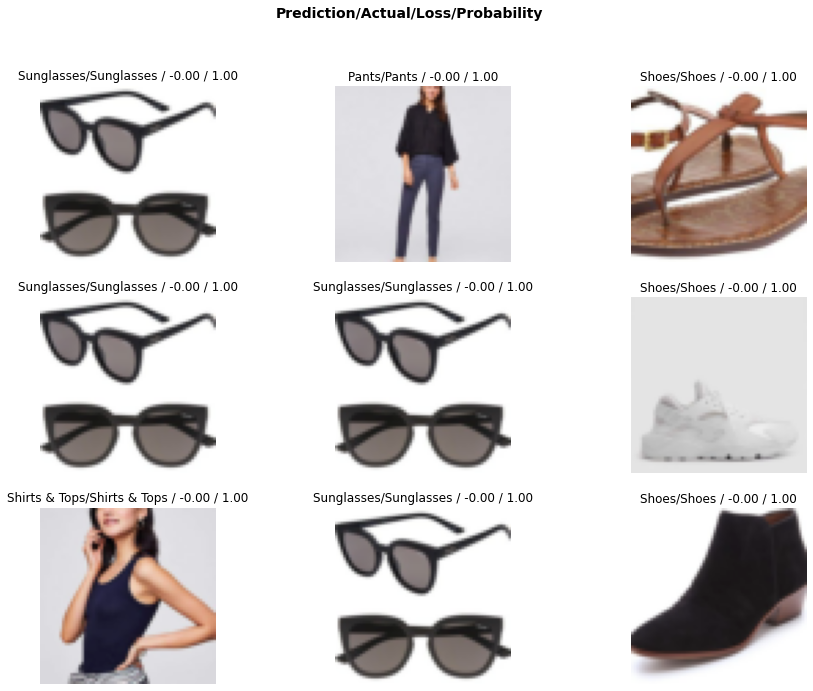

In [ ]:
interp_resnet50 = ClassificationInterpretation.from_learner(learner_resnet50)
interp_resnet50.plot_top_losses(9, largest=False, figsize=(15,11))

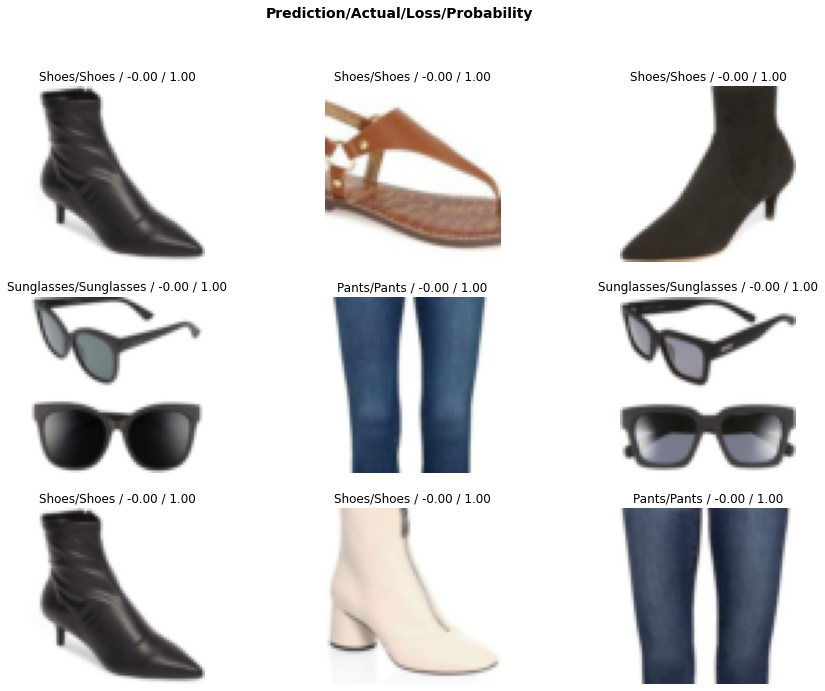

In [ ]:
interp_resnet18 = ClassificationInterpretation.from_learner(learner_resnet18)
interp_resnet18.plot_top_losses(9, largest=False, figsize=(15,11))

In [ ]:
interp_vgg19.plot_confusion_matrix(figsize=(12,12), dpi=60)

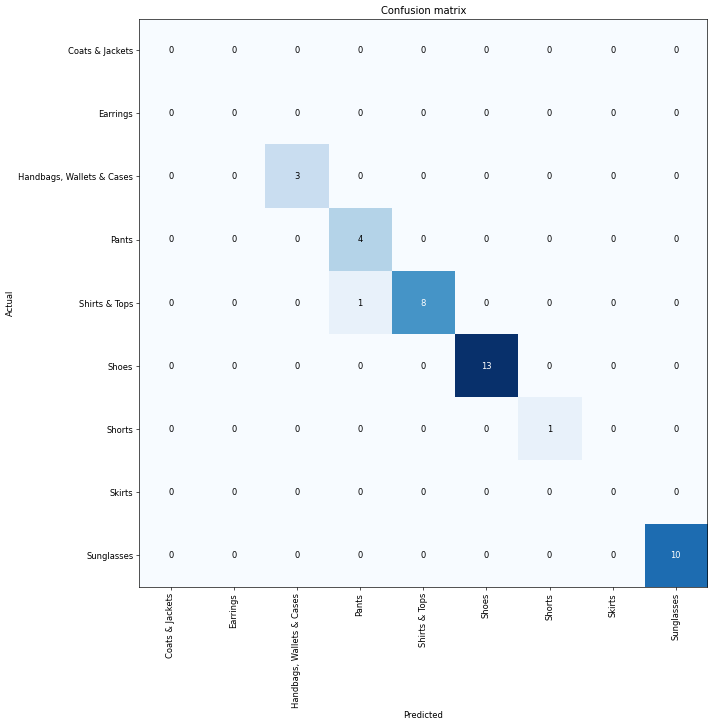

In [ ]:
interp_resnet50.plot_confusion_matrix(figsize=(12,12), dpi=60)

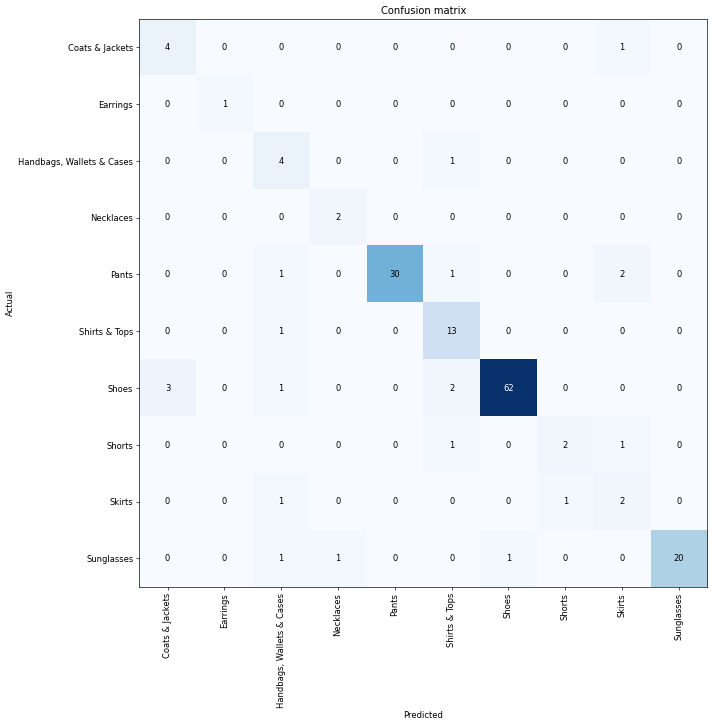

In [ ]:
interp_resnet18.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# saving the model (temporary, will lose model once environment resets)
learner_resnet50.save('resnet-fashion')

Path('/models/resnet-fashion.pth')

In [ ]:
# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner_resnet50.save('/content/gdrive/My Drive/resnet50-fashion')

Mounted at /content/gdrive


Path('/content/gdrive/My Drive/resnet50-fashion.pth')

In [ ]:
# view model details
learner_resnet50.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256